# Personal Protective Equipment Dataset Explorative Data Analysis

## Imports and data loading

### Imports and paths

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
import pandas as pd
import os
import matplotlib.pyplot as plt

In [3]:
train_path = '/dataset/train'

In [4]:
print(os.getcwd())
os.chdir('..')
print(os.getcwd())

/Users/pawelgrabinski/Documents/Pet/surveily/surveily
/Users/pawelgrabinski/Documents/Pet/surveily


### Loading image data

In [5]:
image_data = []
path_to_train_images = os.path.join(os.getcwd(), 'dataset/train/images')
for image_path in os.listdir(path_to_train_images):
    image_size = cv2.imread(os.path.join(path_to_train_images, image_path)).shape
    image_data.append((image_path, image_size))

In [6]:
image_df = pd.DataFrame(image_data, columns=['image_name', 'dimensions'])

In [7]:
image_df = image_df.assign(height=image_df.dimensions.apply(lambda x: x[0]),
                           width=image_df.dimensions.apply(lambda x: x[1]))

In [8]:
image_df = image_df.assign(dimensions=image_df.height.apply(str) + 'x' + image_df.width.apply(str))

In [9]:
image_df = image_df.assign(image_name=image_df.image_name.apply(lambda x: x[:-4]))

### Loading labels data

In [10]:
label_data = []
path_to_train_labels = os.path.join(os.getcwd(), 'dataset/train/labels')
for labels_path in os.listdir(path_to_train_labels):
    with open(os.path.join(path_to_train_labels, labels_path)) as file:
        labels = file.readlines()
    labels = [line.strip().split() for line in labels]
    labels = [[labels_path.replace('.txt',''),] + line for line in labels]
    label_data.extend(labels)

In [11]:
labels_df = pd.DataFrame(label_data, columns=['image_name', 'class', 'x_box_center', 'y_box_center', 'box_width', 'box_height'])

### Merging data

In [12]:
full_df = labels_df.set_index('image_name').join(image_df.set_index('image_name'), on='image_name', how='left', lsuffix='_labels', rsuffix='_image', validate='many_to_one')

In [13]:
full_df = full_df.reset_index()

In [14]:
full_df = full_df.assign()

In [15]:
full_df = full_df.assign(**{
    column: full_df.loc[:, column].astype(float) for column in [
        'x_box_center', 'y_box_center', 'box_width', 'box_height']
    })

In [16]:
full_df = full_df.assign(**{
    column: full_df.loc[:, column].astype(int) for column in ['class', 'height', 'width']
    })

In [17]:
full_df = full_df.assign(aspect=lambda x: x.width/x.height)

## Explorative data analysis

In [18]:
full_df

,image_name,class,x_box_center,y_box_center,box_width,box_height,dimensions,height,width,aspect
0,N5h_img_212_jpg.rf.db84099d70d9d24d23122e6c259...,2,0.310156,0.181250,0.079687,0.129167,720x1280,720,1280,1.777778
1,kp1451_jpg.rf.e080bcf36853b87e451a45a0388328ea,1,0.431250,0.711806,0.076563,0.056944,720x1280,720,1280,1.777778
2,p65621376_jpg.rf.386368b9ea28598e5e2b98a543541aac,7,0.233203,0.411806,0.058594,0.081944,720x1280,720,1280,1.777778
3,PP02img1237_jpg.rf.bcedfc71d7bb8dbd8218d64d7cd...,0,0.141016,0.545139,0.075781,0.084722,720x1280,720,1280,1.777778
4,PP02img1237_jpg.rf.bcedfc71d7bb8dbd8218d64d7cd...,0,0.255859,0.582639,0.083594,0.126389,720x1280,720,1280,1.777778
...,...,...,...,...,...,...,...,...,...,...
19683,frame54--2-_jpg.rf.4a94147bae83d318d28b46b363c...,3,0.701904,0.486654,0.036621,0.050130,1536x2048,1536,2048,1.333333
19684,frame54--2-_jpg.rf.4a94147bae83d318d28b46b363c...,1,0.708008,0.456055,0.039062,0.022786,1536x2048,1536,2048,1.333333
19685,packing1548_jpg.rf.da0852a829d8bb03a3a96169671...,6,0.730859,0.244444,0.058594,0.055556,720x1280,720,1280,1.777778
19686,packing1548_jpg.rf.da0852a829d8bb03a3a96169671...,1,0.158203,0.422917,0.049219,0.048611,720x1280,720,1280,1.777778


### Balans klas

In [19]:
pd.concat([full_df.value_counts('class'), full_df.value_counts('class', normalize=True)], axis=1)

,count,proportion
class,,
5,4885,0.248121
0,3705,0.188186
1,3361,0.170713
6,3293,0.167259
2,1240,0.062983
7,1067,0.054195
10,570,0.028952
8,524,0.026615
9,463,0.023517


In [20]:
full_df.value_counts('class', normalize=True)[:4].sum()

0.7742787484762291

Na początek możemy zauważyć, że zbiór jest zdecydowanie niezbalansowany pod względem klas. Klasa o indeksie `5` stanowi prawie jedną czwartą wszystkich etykiet. Mamy 3 klasy o podobnej liczebności, ale kolejne klasy są już kilkukrotnie mniej liczna, a najmniejliczne klasa stanowi niecały procent obserwacji.

Póki co na tej podstawie możemy powiedzieć, że zbiór nie nadaje się do uczenia modelu bez dodatkowych kroków. Większość algorytmów podczas uczenia będzie zwracać wyniki skupione głównie na 4 najliczniejszych klasach, które stanowią ponad `77%` obserwacji w zbiorze.

By skorygować te problemy można podejść do problemu za pomocą algorytmów, które nie będą wrażliwe na różną liczebność klas. Na przykład możemy podejść do problemu jako klasyfikacji "multi-class multi-label", więc dla każdej z nich możemy spróbować wyuczyć osobny klasyfikator. Jednak niska liczba próbek dla najmniej licznej klasy prawdopodobnie nie pozwali na osiągnięcie zadowalających wyników.

W następnym kroku można zrezygnować z detekcji tych najmniej licznych klas.

### Wymiary i aspekt

In [21]:
full_df.describe()

,class,x_box_center,y_box_center,box_width,box_height,height,width,aspect
count,19688.000000,19688.000000,19688.000000,19688.000000,19688.000000,19688.000000,19688.000000,19688.000000
mean,3.784437,0.506671,0.492225,0.071431,0.108866,842.739537,1399.830049,1.704698
std,2.919947,0.248042,0.201932,0.029964,0.076925,317.136392,384.822919,0.163058
min,0.000000,0.016000,0.031944,0.017969,0.014323,199.000000,200.000000,0.656000
25%,1.000000,0.294922,0.336775,0.052344,0.054036,720.000000,1280.000000,1.777778
50%,5.000000,0.448939,0.484722,0.066406,0.091667,720.000000,1280.000000,1.777778
75%,6.000000,0.732910,0.672852,0.085938,0.144444,720.000000,1280.000000,1.777778
max,11.000000,0.981250,0.965495,0.559375,0.733333,1536.000000,2688.000000,1.866667


Dalej możemy skupić się na wymiarach obrazów. Widzimy, że w zbiorze znajduje się pewna liczba małych obrazów, dla których maksimum dla obu szerokości lub wysokości z występujących jest kilkukortnie większe od minimum. Jednak widzimy, że większość z nich, bo już dla percentyla `25%`, ma wymiary conajmniej 720x1280 czyli ustandaryzowana rozdzielczość HD ready. Widzimy po maksiumum też, że istnieją obrazt większe. Problem z rozmiarem polega na tym, że część modeli może oczekiwać ustandaryzowanej rozdzielczości plików, więc wymagałoby to skalowania niektórych z nich. Jeśli zdecydujemy się skalować w dół, to tracimy część informacji, a jeśli decydujemy się skalować w górę, to mniejsze obrazy nie będą zawierały odpowiednich detali, które zawierają większe obrazy.

Widzimy, że aspekt obrazów również może się znacząco różnić. To nakłada potencjalnie kolejne ograniczenie na modele, które chcemy wykorzystywać. Nawet przy założeniu skalowania części z obrazów, jeśli przeskalujemy je do innego aspektu, to cechy, które rozpoznają modele mogą zostać zdeformowane, a może mieć to istotny wpływ na ich działanie.

Spróbujmy sprawdzić, jaka część zbioru ma aspekt ten sam, co HD ready.

In [22]:
full_df.loc[(full_df.aspect-1280/720).abs()<1e-6].image_name.count()

15710

Czyli mniej od całego zbioru o:

In [23]:
full_df.image_name.count() - full_df.loc[(full_df.aspect-1280/720).abs()<1e-6].image_name.count()

3978

In [24]:
f'Jest to około  {round((full_df.image_name.count() - full_df.loc[(full_df.aspect-1280/720).abs()<1e-6].image_name.count())/full_df.image_name.count()*100,2)}% zbioru'

'Jest to około  20.21% zbioru'

Możemy rozważyć statystykę takiego zbioru.

In [25]:
same_aspect_df = full_df.loc[(full_df.aspect-1280/720).abs()<1e-6]

In [26]:
same_aspect_df.describe()

,class,x_box_center,y_box_center,box_width,box_height,height,width,aspect
count,15710.000000,15710.000000,15710.000000,15710.000000,15710.000000,15710.000000,15710.000000,1.571000e+04
mean,3.255060,0.459667,0.475113,0.073452,0.112459,723.391470,1286.029281,1.777778e+00
std,2.596032,0.237280,0.205214,0.024008,0.065868,34.777928,61.827427,6.661550e-16
min,0.000000,0.019141,0.031944,0.017969,0.015741,720.000000,1280.000000,1.777778e+00
25%,1.000000,0.255469,0.300694,0.056250,0.055556,720.000000,1280.000000,1.777778e+00
50%,5.000000,0.417969,0.461111,0.068750,0.102778,720.000000,1280.000000,1.777778e+00
75%,5.000000,0.693750,0.653472,0.086719,0.151389,720.000000,1280.000000,1.777778e+00
max,10.000000,0.981250,0.949306,0.243750,0.733333,1080.000000,1920.000000,1.777778e+00


In [27]:
same_aspect_df.value_counts('dimensions')

dimensions
720x1280     15562
1080x1920      148
Name: count, dtype: int64

Widzimy, że zostały nam jedynie obrazy ze standardu HD ready i Full HD, gdzie tych drugich. Ponieważ HD ready zawiera już dużo szczegółów, a obrazów Full HD jest niewiele, to możemy postawić hipotezę, że można te drugie przeskalować w dół do HD ready i będziemy mieli jednolity pod względem wymiarów i tym samym aspektu zbiór obrazów.

Sprawdźmy jeszcze, jak zmieniły się liczebności klas po tym odsianiu części obserwacji.

#### Balans klas zbioru o stałym aspekcie

In [28]:
pd.concat([same_aspect_df.value_counts('class'), same_aspect_df.value_counts('class', normalize=True)], axis=1)

,count,proportion
class,,
5,4604,0.293062
0,3679,0.234182
1,2945,0.187460
6,2694,0.171483
7,877,0.055824
2,700,0.044558
9,105,0.006684
4,86,0.005474
8,10,0.000637


Niestety widzimy, że tym samym straciliśmy zupełnie jedynastą klasę, a kolejne cztery mają liczebność mniejszą niż klasa jedynasta przed redukcją zbioru. W tym miejscu powinniśmy zadać sobie pytanie, czy klasy te są kluczowe dla rozwiązania problemu.

Jeśli są, to albo musimy poluzować założenia na temat wymiarów i aspektu albo popracować nad zbiorem danych. Możliwe, że w danych, które odrzuciliśmy są obrazy, które bez utraty zaznaczonych obiektów można dociąć do oczekiwanego przez nas aspektu. 

W przeciwnym razie konieczne będzie rozszerzenie zbioru danych kolejnymi ręcznie oznaczanymi przykładami.

### Zaznaczenia

Sprawdźmy zaznaczenia i czy ich rozkłady zmieniły się po ograniczeniu zbioru.
Na początek cały zbiór.

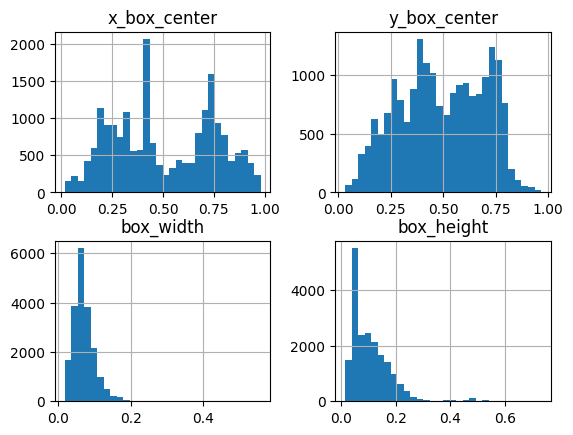

In [29]:
full_df.loc[:, ['x_box_center', 'y_box_center', 'box_width', 'box_height']].hist(bins=30)
plt.show()

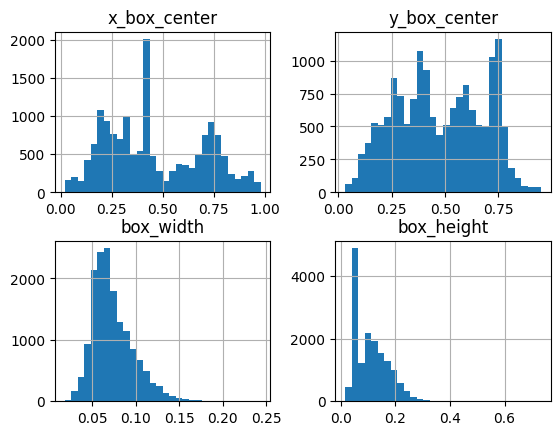

In [30]:
same_aspect_df.loc[:, ['x_box_center', 'y_box_center', 'box_width', 'box_height']].hist(bins=30)
plt.show()

Widzmimy, że rozkłady nie różnią się znacznie. Dla współrzędnych środka widzimy, że zaznaczenia rzadko pojawiają się na środku, ale za to mają dwie mody każda skoncentrowana wokół 0.25 i 0.75 względnego rozmiaru obrazu.

Rozmiary zaznaczeń są w większości znacznie mniejsze od rozmiaru samego obrazu, więc jest szansa, że rzeczywiście te z innymi aspektami dałoby się dosztukować do aspektu HD.

Widzimy także pewne artefakty na tych histogramach, które prawdopodobnie świadczą o tym, że znaczna część zaznaczeń wraz z odpowiadającymi im obrazami pochodzi z tego podobnego procesu, gdzie albo obiekty występują w konkretnym miejscu, albo jest to seria klatek z okresu o niedużej zmienności przedstawianego otoczenia.

In [31]:
full_df.x_box_center.apply(lambda x: round(x, 2)).value_counts()

x_box_center
0.42    850
0.43    601
0.74    558
0.41    537
0.73    533
       ... 
0.09     47
0.10     42
0.97     34
0.98     27
0.02     21
Name: count, Length: 97, dtype: int64

Widzmimy faktycznie dużo próbek dla wartości współrzędnej poziomej o wartości 0.41-0.43.

In [32]:
full_df.loc[(full_df.x_box_center <0.44) & (full_df.x_box_center > 0.4)].image_name.apply(lambda x: x.split('_')[0][:5]).value_counts()

image_name
PP02i    199
nglov     48
frame     33
NVR-0     21
helme     18
        ... 
00545      1
kp477      1
kp787      1
kp661      1
kp357      1
Name: count, Length: 824, dtype: int64

Widzimy po nazwach plików, że faktycznie znaczna część z obrazów, które mają te wartości położeń zaznaczeń, ma nazwy zaczynające się podobnie. Nadmierna liczba próbek z tego samego procesu może mieć silną korelację, co może prowadzić do problemów z generalizacją modeli, które nauczą się cech tła zamiast cech obiektów, które mają wykrywać.

#### Liczba zanzaczeń

Możemy jeszcze zobaczyć, jak rozkłada się liczba zaznaczeń per obraz w obu wersjach zbioru.

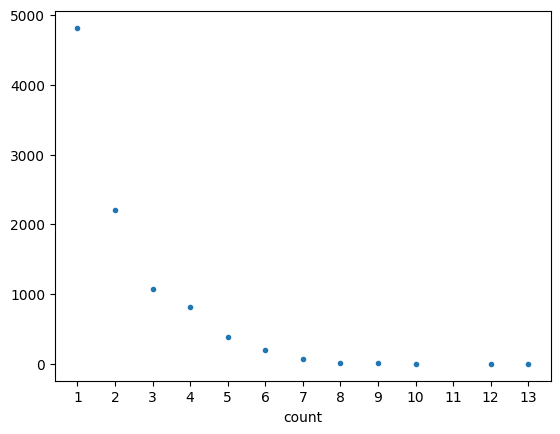

In [33]:
full_df.image_name.value_counts().value_counts().plot(style='.')
plt.xticks(range(int(1), 14))
plt.show()

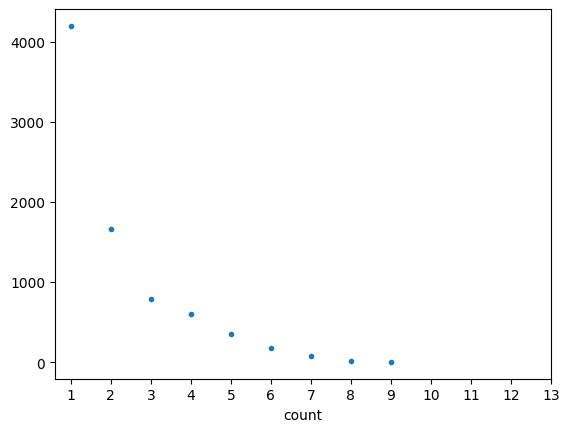

In [34]:
same_aspect_df.image_name.value_counts().value_counts().plot(style='.')
plt.xticks(range(int(1), 14))
plt.show()

Widzimy, że większość obrazów rzeczywiście ma niewiele zaznaczeń 1-5. Co ciekawe odsiewając obrazy o innych aspektach straciliśmy te, które miały bardzo duże liczby zaznaczeń, co może być przypadkiem brzegowym, który i tak byłby trudno dla modelu do rozpoznania.

## Podsumowanie

1. Głównym problemem zbioru danych jest niezbalansowanie klas.
2. Część obrazów jest w nietypowej rozdzielczości. Mają inne aspekt albo bardzo małe lub duże wymiary.
3. Po odsianiu nietypowych obrazów niezbalansowanie klas się pogłębia.

  #### Co można zrobić?
1. Trzeba przejrzeć dostępne modele i zrewidować, czy problem balansu klas, wymiarów lub aspektu jest istotny.
2. Edytować nietypowe obrazy, by przy pomocy ręcznych narzędzi cięcia i skalowania ustandaryzować je.
3. W skrajnym przypadku poszerzyć zbiór o nowe ręcznie oznaczane próbki.